In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from keras import models
from keras import layers
from keras.preprocessing import image
from keras.utils import plot_model
from keras import optimizers
import cv2
from tensorflow.keras.preprocessing.image import load_img, img_to_array

In [4]:
train_path = '/kaggle/input/fer2013/train'
test_path = '/kaggle/input/fer2013/test'


# Tinitializes an ImageDataGenerator object named train_datagen.
# object will be responsible for generating augmented images from the original training data.
datagen_train = image.ImageDataGenerator(
    horizontal_flip=True, # Randomly flips images horizontally
    rescale = 1./255, # scales the pixel values of the images to the range [0, 1]
    zoom_range = 0.2, # the image can be zoomed in or out by a factor of up to 30%.
)


# uses the flow_from_directory method of the ImageDataGenerator
# to generate batches of augmented images from 
# a directory containing the original training images
train_generator = datagen_train.flow_from_directory(
    train_path,
    target_size=(48, 48), # img_rows, img_cols)
    color_mode="grayscale", # Specifies that the images should be read in grayscale mode.
    batch_size=64, # Specifies the size of the batches of augmented images that will be generated.
    class_mode='categorical',  # ecifies the type of labels.
    shuffle=True # Shuffles the order of the images within each batch.
)

datagen_validation = image.ImageDataGenerator(
    horizontal_flip=True,
    rescale = 1./255,
    zoom_range = 0.2,
)
validation_generator = datagen_validation.flow_from_directory(
    test_path,
    target_size=(48, 48), #(img_rows, img_cols)
    color_mode="grayscale",
    batch_size=64,
    class_mode='categorical',
)

Found 28709 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


In [5]:
"""
Batch normalization normalizes the activations of the previous layer, 
which can help stabilize and accelerate the training process.

Dropout Layers:
Dropout helps prevent overfitting by randomly setting a fraction of input units to zero during training.

Flatten Layer:
The Flatten layer is added to flatten the input photos into a one-dimensional vector.
This is necessary before connecting to fully connected layers.

Fully Connected Layers:
Two fully connected (Dense) layers are added with 256 and 128 units, respectively, and ReLU activation functions.

BatchNormalization is applied after each fully connected layer.
Dropout layers with a dropout rate of 0.25 are added after each fully connected layer to further prevent overfitting.

Output Layer:
The output layer has 7 units (bec. it's a multi-class classification task with 7 classes)
and uses the softmax activation function
"""

model = models.Sequential()

# Add several densely connected layers
model.add(layers.Flatten(input_shape=(48, 48, 1)))

model.add(layers.Dense(1024, activation='relu'))
model.add(layers.BatchNormalization())

model.add(layers.Dense(512, activation='relu'))
model.add(layers.BatchNormalization())

model.add(layers.Dense(512, activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.35))

model.add(layers.Dense(256, activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.5))

# Output Layer
model.add(layers.Dense(7, activation='softmax'))

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 2304)              0         
                                                                 
 dense (Dense)               (None, 1024)              2360320   
                                                                 
 batch_normalization (Batch  (None, 1024)              4096      
 Normalization)                                                  
                                                                 
 dense_1 (Dense)             (None, 512)               524800    
                                                                 
 batch_normalization_1 (Bat  (None, 512)               2048      
 chNormalization)                                                
                                                                 
 dense_2 (Dense)             (None, 512)               2

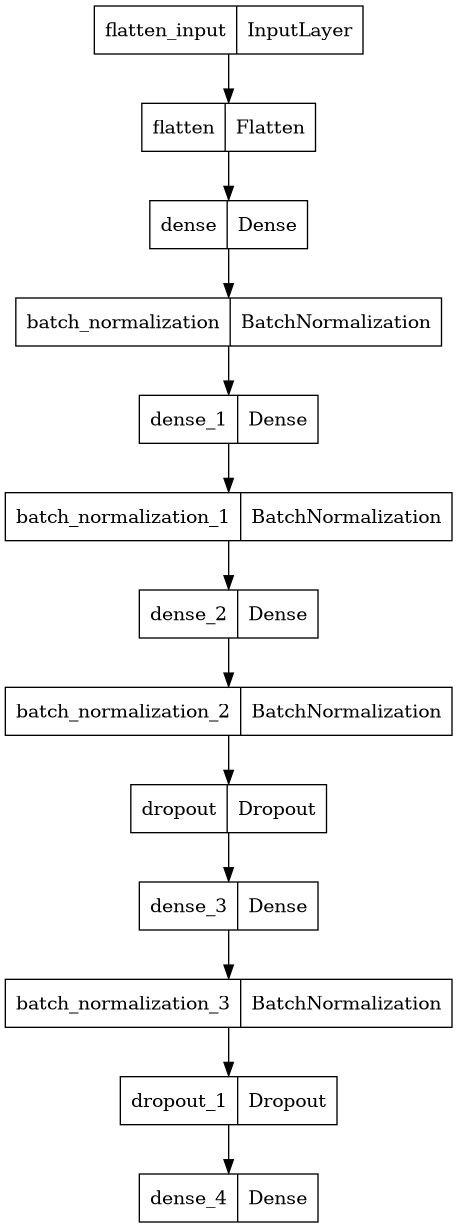

In [6]:
plot_model(model)

In [7]:
# let's build the model
history = model.fit(x = train_generator, epochs = 100, validation_data = validation_generator)

Epoch 1/100
449/449 [==============================] - 201s 441ms/step - loss: 2.1578 - accuracy: 0.2424 - val_loss: 1.7343 - val_accuracy: 0.3016
Epoch 2/100
449/449 [==============================] - 58s 129ms/step - loss: 1.7719 - accuracy: 0.3070 - val_loss: 1.6871 - val_accuracy: 0.3289
Epoch 3/100
449/449 [==============================] - 59s 132ms/step - loss: 1.6997 - accuracy: 0.3252 - val_loss: 1.6643 - val_accuracy: 0.3413
Epoch 4/100
449/449 [==============================] - 58s 129ms/step - loss: 1.6732 - accuracy: 0.3379 - val_loss: 1.6938 - val_accuracy: 0.3264
Epoch 5/100
449/449 [==============================] - 71s 158ms/step - loss: 1.6619 - accuracy: 0.3399 - val_loss: 1.6920 - val_accuracy: 0.3384
Epoch 6/100
449/449 [==============================] - 65s 144ms/step - loss: 1.6470 - accuracy: 0.3498 - val_loss: 1.9746 - val_accuracy: 0.2458
Epoch 7/100
449/449 [==============================] - 64s 142ms/step - loss: 1.6331 - accuracy: 0.3548 - val_loss: 1.7229 

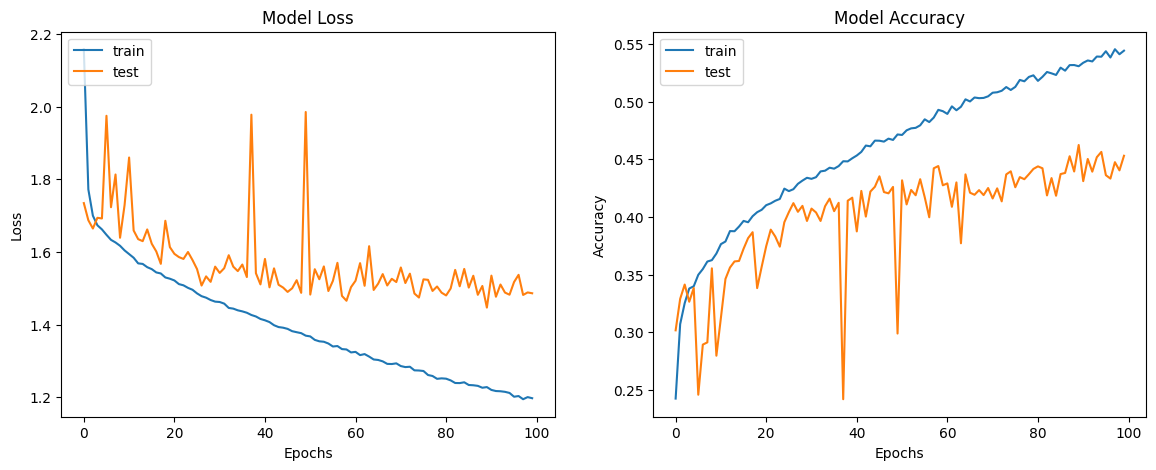

In [8]:
# Plotting the loss & accuracy
plt.figure(figsize=(14,5))
plt.subplot(1,2,2)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['train', 'test'], loc='upper left')

plt.subplot(1,2,1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [9]:
train_loss, train_accu = model.evaluate(train_generator)
test_loss, test_accu = model.evaluate(validation_generator)
print("final train accuracy = {:.2f} , validation accuracy = {:.2f}".format(train_accu*100, test_accu*100))

113/113 [==============================] - 12s 102ms/step - loss: 1.4884 - accuracy: 0.4468
final train accuracy = 58.69 , validation accuracy = 44.68


In [10]:
label_dict = {0:'anger', 1:'disgust', 2:'fear', 3:'happiness', 4: 'neutral', 5: 'sad', 6: 'surprise'}
def predict(url):
    img = plt.imread(url)
    plt.imshow(img)
    data = img_to_array(img)
    data = data/255
    data = tf.image.resize(data, (48, 48))
    samples = np.expand_dims(data, 0)
    samples = np.resize(samples, (1, 48, 48, 1))
    result = model.predict(samples)
    result = list(result[0])
#     print(result)
    predictions = label_dict[np.argmax(result)]
    return predictions

1/1 [==============================] - 0s 197ms/step


'happiness'

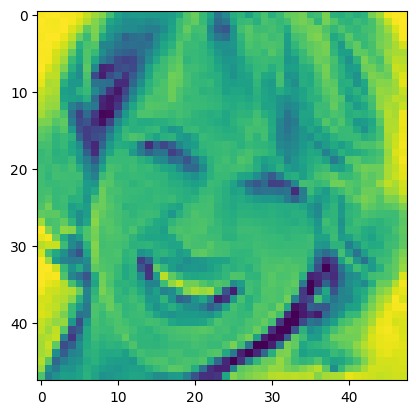

In [11]:
path = "/kaggle/input/fer2013/train/happy/Training_10080933.jpg"
predict(path)

In [14]:
# save model structure in jason file
model_json = model.to_json()
with open("ann_model.json", "w") as json_file:
    json_file.write(model_json)

# save trained model weight in .h5 file
model.save_weights('ann_model.h5')